# Petro Tweets Preprocessing for Text Generation


1. Loads tweet data from Hugging Face
2. Cleans and preprocesses text


## Data Loading

In [109]:
%pip install datasets pandas matplotlib seaborn nltk

Note: you may need to restart the kernel to use updated packages.


In [110]:
from datasets import load_dataset
import pandas as pd
import re
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download NLTK tokenizer data 
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [111]:
# Load and convert to DataFrame
dataset = load_dataset("jhonparra18/petro-tweets")
df = pd.DataFrame(dataset['train'])
print(f"Loaded {len(df)} tweets from {df['User'].nunique()} unique user(s)")

Loaded 19790 tweets from 1 unique user(s)


In [ ]:
from nltk.tokenize import word_tokenize

def clean_and_tokenize_tweet(text):
    """    
    Steps:
    1. Remove URLs
    2. Normalize @mentions to <USER>
    3. Normalize #hashtags to <HASHTAG>
    4. Normalize numbers to <NUM>
    5. Convert to lowercase
    6. Tokenize with NLTK
    7. Add start/end tokens
    
    Returns: list of tokens
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Normalize @mentions to <USER>
    text = re.sub(r'@\w+', '<USER>', text)
    
    # Normalize #hashtags to <HASHTAG>
    text = re.sub(r'#\w+', '<HASHTAG>', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize with NLTK (Spanish language)
    tokens = word_tokenize(text, language='spanish')
    
    # Normalize numbers to <NUM>
    tokens = ['<NUM>' if token.replace('.', '').replace(',', '').isdigit() else token for token in tokens]
    
    # Add start and end tokens
    tokens = ['<s>'] + tokens + ['</s>']
    
    return tokens

In [ ]:
# Apply preprocessing and tokenization
df['tokens'] = df['Tweet'].apply(clean_and_tokenize_tweet)

# Remove empty tweets
original_count = len(df)
df = df[df['tokens'].apply(len) > 2].reset_index(drop=True)

# Add metrics
df['token_count'] = df['tokens'].apply(len)
df['has_user_mention'] = df['tokens'].apply(lambda x: '<USER>' in x)
df['has_hashtag'] = df['tokens'].apply(lambda x: '<HASHTAG>' in x)
df['has_number'] = df['tokens'].apply(lambda x: '<NUM>' in x)

print(f"Total tweets after tokenization: {len(df)}")

# Basic statistics
print("\n=== Tokenization Statistics ===")
print(f"\nToken count per tweet:")
print(f"  Mean: {df['token_count'].mean():.1f}")
print(f"  Median: {df['token_count'].median():.1f}")
print(f"  Min: {df['token_count'].min()}")
print(f"  Max: {df['token_count'].max()}")
print(f"\nTweets with <USER> mentions: {df['has_user_mention'].sum()} ({df['has_user_mention'].mean()*100:.1f}%)")
print(f"Tweets with <HASHTAG>: {df['has_hashtag'].sum()} ({df['has_hashtag'].mean()*100:.1f}%)")
print(f"Tweets with <NUM>: {df['has_number'].sum()} ({df['has_number'].mean()*100:.1f}%)")

# Show example
print("\n=== Example Tweet ===")
print(f"Original: {df['Tweet'].iloc[0]}")
print(f"Tokens: {df['tokens'].iloc[0]}")

Total tweets after tokenization: 19613
Tweets removed (empty after cleaning): 0

=== Tokenization Statistics ===

Token count per tweet:
  Mean: 37.4
  Median: 41.0
  Min: 3
  Max: 71

Tweets with <USER> mentions: 0 (0.0%)
Tweets with <HASHTAG>: 0 (0.0%)
Tweets with <NUM>: 3240 (16.5%)

=== Example Tweet ===
Original: La prensa engolosinada con el dinero público que a manos llenas le entrega Peñalosa, no solo no registra el hecho que se desplomó en 1.6 millones los viales diarios en el sistema de transporte público, sino algo peor:

Que en Bogotá la mortalidad infantil aumentó respecto al 2015
Tokens: ['<s>', 'la', 'prensa', 'engolosinada', 'con', 'el', 'dinero', 'público', 'que', 'a', 'manos', 'llenas', 'le', 'entrega', 'peñalosa', ',', 'no', 'solo', 'no', 'registra', 'el', 'hecho', 'que', 'se', 'desplomó', 'en', '<NUM>', 'millones', 'los', 'viales', 'diarios', 'en', 'el', 'sistema', 'de', 'transporte', 'público', ',', 'sino', 'algo', 'peor', ':', 'que', 'en', 'bogotá', 'la', 'mortali

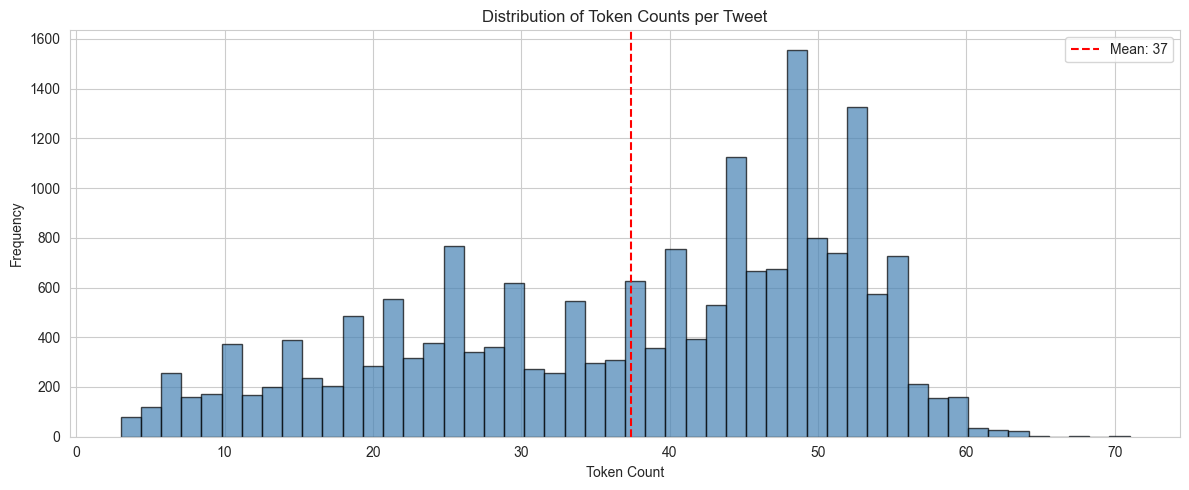

In [114]:
# Visualize token count distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.hist(df['token_count'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df['token_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["token_count"].mean():.0f}')
ax.set_xlabel('Token Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Token Counts per Tweet')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Build vocabulary from all tokens
vocabulary = set()
for tokens in df['tokens']:
    vocabulary.update(tokens)

vocabulary_sorted = sorted(vocabulary)

print(f"Total unique tokens in vocabulary: {len(vocabulary_sorted)}")
print(f"\nSpecial tokens: {[t for t in vocabulary_sorted if t.startswith('<')]}")
print(f"\nFirst 30 regular tokens:")
regular_tokens = [t for t in vocabulary_sorted if not t.startswith('<')]
print(regular_tokens[:30])
print(f"\nLast 30 regular tokens:")
print(regular_tokens[-30:])


=== Vocabulary Statistics ===
Total unique tokens in vocabulary: 30423

Special tokens: ['<', '</s>', '<NUM>', '<s>']

First 30 regular tokens (alphabetically):
['!', '$', '%', '&', "'", "''", "'es", "'llegó", "'viva", '(', ')', '*', '+', ',', '-', '-35', '-a', '-como', '-en', '-haciendo', '-impuesto', '-reducir', '-se', '-up', '.', '..', '...', '....', '.cada', '.com']

Last 30 regular tokens (alphabetically):
['únicas', 'único', 'únicos', 'úniica', 'ĺa', 'žižek', '“', '”', '•aguachica', '•cantagallo', '•el', '•la', '•para', '•puerto', '•recaudar', '•san', '•seremos', '•vamos', '…', '∆', '♥️', '❤️🇨🇴', '⬇️', '🇨🇴', '👇🇨🇴', '👇👇👇', '👉', '💟', '🥈', '🧵']
